In [ ]:
!pip install --upgrade opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 MB 30.7 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.8.0.76
    Uninstalling opencv-python-4.8.0.76:
      Successfully uninstalled opencv-python-4.8.0.76


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical
from sklearn.model_selection import cross_validate
from keras.layers import Input


In [ ]:
import os
import cv2
from sklearn.utils import shuffle

# Data augmentation

## 증강 X funtion

In [ ]:
# 증강x
def load_images_and_labels_parallel(data_dir):
    images = []
    labels = []

    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # 이미지를 RGB 형식으로 변환
                img = cv2.resize(img, (32, 32))  # 이미지 크기 조절

                # 이미지 데이터를 리스트에 추가
                images.append(img)
                # 레이블을 리스트에 추가
                labels.append(folder_name)

    return shuffle(images, labels, random_state=42)


## 증강 O function


랜덤으로 하나의 증강 방식만을 선택 후 적용

In [ ]:
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

def load_images_and_labels(data_dir):
    images = []
    labels = []

    # 랜덤으로 선택할 증강 리스트
    augmentation_options = [
        {'name': 'rotation', 'param': 40},
        {'name': 'width_shift', 'param': 0.2},
        {'name': 'height_shift', 'param': 0.2},
        {'name': 'shear', 'param': 0.2},
        {'name': 'zoom', 'param': 0.2},
        {'name': 'horizontal_flip', 'param': True},
    ]

    # 데이터 증강을 위한 ImageDataGenerator 정의
    datagen = ImageDataGenerator()

    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (32, 32))

                # 원본 이미지를 리스트에 추가
                images.append(img)
                labels.append(folder_name)

                # 랜덤으로 선택한 증강 옵션을 적용
                selected_augmentations = random.sample(augmentation_options, k=random.randint(0, len(augmentation_options)))
                for aug_option in selected_augmentations:
                    if aug_option['name'] == 'rotation':
                        img = ImageDataGenerator(rotation_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'width_shift':
                        img = ImageDataGenerator(width_shift_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'height_shift':
                        img = ImageDataGenerator(height_shift_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'shear':
                        img = ImageDataGenerator(shear_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'zoom':
                        img = ImageDataGenerator(zoom_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'horizontal_flip':
                        img = ImageDataGenerator(horizontal_flip=aug_option['param']).random_transform(img)

                    # 증강된 이미지를 리스트에 추가
                    images.append(img)
                    labels.append(folder_name)
    return shuffle(images, labels, random_state=42)

# Model

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import Adam
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

## vgg16 baseline model

### baseline + 증강X : 0.7387279391288757**


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels_parallel(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")


Epoch 1/100
3/3 [==============================] - 6s 428ms/step - loss: 63.1705 - accuracy: 0.5922 - val_loss: 0.6919 - val_accuracy: 0.7308
Epoch 2/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6866 - accuracy: 0.6731 - val_loss: 0.5700 - val_accuracy: 0.7308
Epoch 3/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6262 - accuracy: 0.6731 - val_loss: 0.6238 - val_accuracy: 0.7308
Epoch 4/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6377 - accuracy: 0.6731 - val_loss: 0.6181 - val_accuracy: 0.7308
Epoch 5/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6342 - accuracy: 0.6731 - val_loss: 0.5794 - val_accuracy: 0.7308
Epoch 6/100
3/3 [==============================] - 0s 32ms/step - loss: 0.6116 - accuracy: 0.6731 - val_loss: 0.5554 - val_accuracy: 0.7308
Epoch 7/100
3/3 [==============================] - 0s 32ms/step - loss: 0.5983 - accuracy: 0.6731 - val_loss: 0.5543 - val_accuracy: 0.7308
Epoch 8/100
3/3 [=

### baseline + 증강 O : 0.7418238639831543

In [ ]:
# 이거다!!!
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import Adam

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")


Epoch 1/100
10/10 [==============================] - 18s 214ms/step - loss: 16.6866 - accuracy: 0.7123 - val_loss: 0.6780 - val_accuracy: 0.6933
Epoch 2/100
10/10 [==============================] - 1s 58ms/step - loss: 0.6533 - accuracy: 0.7123 - val_loss: 1.0142 - val_accuracy: 0.6933
Epoch 3/100
10/10 [==============================] - 1s 58ms/step - loss: 0.6667 - accuracy: 0.7123 - val_loss: 0.6255 - val_accuracy: 0.6933
Epoch 4/100
10/10 [==============================] - 1s 59ms/step - loss: 0.6077 - accuracy: 0.7123 - val_loss: 0.6173 - val_accuracy: 0.6933
Epoch 5/100
10/10 [==============================] - 1s 58ms/step - loss: 0.6020 - accuracy: 0.7123 - val_loss: 0.6188 - val_accuracy: 0.6933
Epoch 6/100
10/10 [==============================] - 1s 59ms/step - loss: 0.6002 - accuracy: 0.7123 - val_loss: 0.6164 - val_accuracy: 0.6933
Epoch 7/100
10/10 [==============================] - 1s 59ms/step - loss: 0.6020 - accuracy: 0.7123 - val_loss: 0.6169 - val_accuracy: 0.6933
Epo

### baseline + Random 증강 :  0.7055885910987854



In [ ]:
# 이거다!!!
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import Adam

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=128, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")


NameError: ignored

## AdamW + Random 증강 : 0.8914704561233521

In [ ]:
# 이거다!!!
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import AdamW

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels_parallel_argumentation(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(4096, activation='relu'))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])


# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/50
10/10 [==============================] - 17s 196ms/step - loss: 0.5667 - accuracy: 0.6882 - val_loss: 0.5570 - val_accuracy: 0.6323
Epoch 2/50
10/10 [==============================] - 0s 48ms/step - loss: 0.5245 - accuracy: 0.6979 - val_loss: 0.5108 - val_accuracy: 0.6323
Epoch 3/50
10/10 [==============================] - 0s 47ms/step - loss: 0.4642 - accuracy: 0.7431 - val_loss: 0.4963 - val_accuracy: 0.8000
Epoch 4/50
10/10 [==============================] - 0s 48ms/step - loss: 0.3920 - accuracy: 0.8110 - val_loss: 0.4706 - val_accuracy: 0.7935
Epoch 5/50
10/10 [==============================] - 0s 47ms/step - loss: 0.3266 - accuracy: 0.8756 - val_loss: 0.3814 - val_accuracy: 0.7871
Epoch 6/50
10/10 [==============================] - 0s 48ms/step - loss: 0.3495 - accuracy: 0.8514 - val_loss: 0.4219 - val_accuracy: 0.7742
Epoch 7/50
10/10 [==============================] - 0s 47ms/step - loss: 0.5312 - accuracy: 0.7173 - val_loss: 0.5633 - val_accuracy: 0.6323
Epoch 8/50


## AdamW + Random 증강 + dropout 3개 : 0.8707917928695679

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import AdamW

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels_parallel_argumentation(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5


    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])


# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/100
10/10 [==============================] - 8s 143ms/step - loss: 0.6304 - accuracy: 0.6737 - val_loss: 0.6207 - val_accuracy: 0.6323
Epoch 2/100
10/10 [==============================] - 1s 54ms/step - loss: 0.5731 - accuracy: 0.6979 - val_loss: 0.5867 - val_accuracy: 0.6323
Epoch 3/100
10/10 [==============================] - 1s 55ms/step - loss: 0.5133 - accuracy: 0.6979 - val_loss: 0.5261 - val_accuracy: 0.6323
Epoch 4/100
10/10 [==============================] - 1s 54ms/step - loss: 0.4443 - accuracy: 0.6979 - val_loss: 0.5307 - val_accuracy: 0.6387
Epoch 5/100
10/10 [==============================] - 1s 54ms/step - loss: 0.4184 - accuracy: 0.7528 - val_loss: 0.5049 - val_accuracy: 0.7742
Epoch 6/100
10/10 [==============================] - 1s 54ms/step - loss: 0.3871 - accuracy: 0.8029 - val_loss: 0.5125 - val_accuracy: 0.7806
Epoch 7/100
10/10 [==============================] - 1s 54ms/step - loss: 0.3706 - accuracy: 0.8788 - val_loss: 0.5866 - val_accuracy: 0.7097
Epoch

L2 규제 추가


## AdamW + Random 증강 + L2규제 + dropout 3개 :0.825571846961975

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import AdamW
from keras.regularizers import l2


# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5


    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])


# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/100
10/10 [==============================] - 16s 105ms/step - loss: 48.7425 - accuracy: 0.6672 - val_loss: 46.2649 - val_accuracy: 0.6323
Epoch 2/100
10/10 [==============================] - 0s 23ms/step - loss: 44.3580 - accuracy: 0.6979 - val_loss: 41.9837 - val_accuracy: 0.6323
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 40.1918 - accuracy: 0.6979 - val_loss: 37.9993 - val_accuracy: 0.6323
Epoch 4/100
10/10 [==============================] - 0s 22ms/step - loss: 36.3433 - accuracy: 0.6979 - val_loss: 34.3142 - val_accuracy: 0.6323
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 32.8182 - accuracy: 0.6979 - val_loss: 31.1015 - val_accuracy: 0.6323
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 29.6872 - accuracy: 0.6979 - val_loss: 27.9880 - val_accuracy: 0.6323
Epoch 7/100
10/10 [==============================] - 0s 22ms/step - loss: 26.6702 - accuracy: 0.6979 - val_loss: 25.1647 - val_accurac

랜덤 증강 + dropout추가 + *L2규제*

## AdamW + Random 증강 + L2규제 + dropout 6개 : 0.9095182180404663

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import AdamW
from keras.regularizers import l2


# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5


    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])


# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/100
10/10 [==============================] - 5s 49ms/step - loss: 48.8317 - accuracy: 0.6931 - val_loss: 46.4679 - val_accuracy: 0.6323
Epoch 2/100
10/10 [==============================] - 0s 22ms/step - loss: 44.6285 - accuracy: 0.6979 - val_loss: 42.3824 - val_accuracy: 0.6323
Epoch 3/100
10/10 [==============================] - 0s 22ms/step - loss: 40.6059 - accuracy: 0.6979 - val_loss: 38.5333 - val_accuracy: 0.6323
Epoch 4/100
10/10 [==============================] - 0s 23ms/step - loss: 36.8267 - accuracy: 0.6979 - val_loss: 34.8817 - val_accuracy: 0.6323
Epoch 5/100
10/10 [==============================] - 0s 23ms/step - loss: 33.3177 - accuracy: 0.6979 - val_loss: 31.5314 - val_accuracy: 0.7742
Epoch 6/100
10/10 [==============================] - 0s 22ms/step - loss: 30.1027 - accuracy: 0.7706 - val_loss: 28.5102 - val_accuracy: 0.7935
Epoch 7/100
10/10 [==============================] - 0s 23ms/step - loss: 27.1733 - accuracy: 0.8352 - val_loss: 25.7173 - val_accuracy:

## AdamW + Random 증강 + L2규제 + dropout 6개 + epoch 100 -> 200 : 0.8489317059516907

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import AdamW
from keras.regularizers import l2


# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5


    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])


# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/200
10/10 [==============================] - 5s 51ms/step - loss: 48.7980 - accuracy: 0.6753 - val_loss: 46.3353 - val_accuracy: 0.6323
Epoch 2/200
10/10 [==============================] - 0s 23ms/step - loss: 44.4183 - accuracy: 0.6979 - val_loss: 42.1271 - val_accuracy: 0.6323
Epoch 3/200
10/10 [==============================] - 0s 23ms/step - loss: 40.2994 - accuracy: 0.6979 - val_loss: 38.0978 - val_accuracy: 0.6323
Epoch 4/200
10/10 [==============================] - 0s 22ms/step - loss: 36.4451 - accuracy: 0.6979 - val_loss: 34.4329 - val_accuracy: 0.6323
Epoch 5/200
10/10 [==============================] - 0s 23ms/step - loss: 32.8932 - accuracy: 0.6979 - val_loss: 31.0752 - val_accuracy: 0.6323
Epoch 6/200
10/10 [==============================] - 0s 22ms/step - loss: 29.6127 - accuracy: 0.6979 - val_loss: 28.0503 - val_accuracy: 0.6581
Epoch 7/200
10/10 [==============================] - 0s 22ms/step - loss: 26.6919 - accuracy: 0.7383 - val_loss: 25.1901 - val_accuracy:

## AdamW + Random 증강 + L2규제 + dropout 3개 + Early stopping : 0.8811646461486816


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import AdamW
from keras.regularizers import l2
from keras.callbacks import EarlyStopping

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)


# 모델 생성 함수
def create_vgg16_model_with_early_stopping():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5


    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model_with_early_stopping()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")


Epoch 1/200
10/10 [==============================] - 5s 62ms/step - loss: 48.6130 - accuracy: 0.6785 - val_loss: 46.0315 - val_accuracy: 0.6323
Epoch 2/200
10/10 [==============================] - 0s 24ms/step - loss: 44.0917 - accuracy: 0.6979 - val_loss: 41.7011 - val_accuracy: 0.6323
Epoch 3/200
10/10 [==============================] - 0s 22ms/step - loss: 39.9037 - accuracy: 0.6979 - val_loss: 37.7825 - val_accuracy: 0.6323
Epoch 4/200
10/10 [==============================] - 0s 22ms/step - loss: 36.0235 - accuracy: 0.6979 - val_loss: 33.9805 - val_accuracy: 0.6323
Epoch 5/200
10/10 [==============================] - 0s 22ms/step - loss: 32.4411 - accuracy: 0.7060 - val_loss: 30.7263 - val_accuracy: 0.7161
Epoch 6/200
10/10 [==============================] - 0s 22ms/step - loss: 29.1959 - accuracy: 0.8142 - val_loss: 27.5896 - val_accuracy: 0.7613
Epoch 7/200
10/10 [==============================] - 0s 22ms/step - loss: 26.2492 - accuracy: 0.8546 - val_loss: 24.8526 - val_accuracy:

Exception ignored in: <function _xla_gc_callback at 0x7fc5a0612440>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/lib/__init__.py", line 101, in _xla_gc_callback
    def _xla_gc_callback(*args):
KeyboardInterrupt: 


10/10 [==============================] - 5s 60ms/step - loss: 48.6603 - accuracy: 0.6543 - val_loss: 46.0083 - val_accuracy: 0.7161
Epoch 2/200
10/10 [==============================] - 0s 24ms/step - loss: 44.2107 - accuracy: 0.6769 - val_loss: 41.8169 - val_accuracy: 0.7161
Epoch 3/200
10/10 [==============================] - 0s 25ms/step - loss: 40.0291 - accuracy: 0.6769 - val_loss: 37.7434 - val_accuracy: 0.7161
Epoch 4/200
10/10 [==============================] - 0s 22ms/step - loss: 36.1550 - accuracy: 0.6769 - val_loss: 34.0387 - val_accuracy: 0.7161
Epoch 5/200
10/10 [==============================] - 0s 22ms/step - loss: 32.5919 - accuracy: 0.6769 - val_loss: 30.7339 - val_accuracy: 0.7161
Epoch 6/200
10/10 [==============================] - 0s 22ms/step - loss: 29.3697 - accuracy: 0.6769 - val_loss: 27.6597 - val_accuracy: 0.7161
Epoch 7/200
10/10 [==============================] - 0s 22ms/step - loss: 26.4342 - accuracy: 0.6769 - val_loss: 24.8700 - val_accuracy: 0.7161
Epoc

## AdamW + Random 증강 + L2규제 + dropout 3개 + Early stopping + epoch 150 + batch_noramalization : 0.9147465348243713


In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.applications import ResNet50
from keras.optimizers import AdamW
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)


# 모델 생성 함수
def create_vgg16_model_with_early_stopping():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model_with_early_stopping()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=150, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")


Epoch 1/150
10/10 [==============================] - 9s 91ms/step - loss: 50.4873 - accuracy: 0.5380 - val_loss: 49.4637 - val_accuracy: 0.6323
Epoch 2/150
10/10 [==============================] - 0s 32ms/step - loss: 49.0633 - accuracy: 0.6834 - val_loss: 48.2314 - val_accuracy: 0.6323
Epoch 3/150
10/10 [==============================] - 0s 33ms/step - loss: 47.6388 - accuracy: 0.7835 - val_loss: 47.0216 - val_accuracy: 0.6323
Epoch 4/150
10/10 [==============================] - 0s 31ms/step - loss: 46.2798 - accuracy: 0.8465 - val_loss: 45.8221 - val_accuracy: 0.6323
Epoch 5/150
10/10 [==============================] - 0s 29ms/step - loss: 44.8349 - accuracy: 0.9047 - val_loss: 44.6742 - val_accuracy: 0.6323
Epoch 6/150
10/10 [==============================] - 0s 29ms/step - loss: 43.4430 - accuracy: 0.9467 - val_loss: 43.5412 - val_accuracy: 0.6323
Epoch 7/150
10/10 [==============================] - 0s 30ms/step - loss: 42.0354 - accuracy: 0.9855 - val_loss: 42.4371 - val_accuracy:

### AdamW + Random 증강 + L2규제 + dropout 3개 + Early stopping + epoch 200 + batch_noramalization : 0.90056973695755

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import AdamW
from keras.regularizers import l2
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)


# 모델 생성 함수
def create_vgg16_model_with_early_stopping():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model_with_early_stopping()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")


Epoch 1/200
10/10 [==============================] - 9s 86ms/step - loss: 50.5892 - accuracy: 0.5202 - val_loss: 49.5206 - val_accuracy: 0.6323
Epoch 2/200
10/10 [==============================] - 0s 29ms/step - loss: 49.1571 - accuracy: 0.6607 - val_loss: 48.3311 - val_accuracy: 0.6323
Epoch 3/200
10/10 [==============================] - 0s 30ms/step - loss: 47.7285 - accuracy: 0.7658 - val_loss: 47.1125 - val_accuracy: 0.6323
Epoch 4/200
10/10 [==============================] - 0s 29ms/step - loss: 46.3083 - accuracy: 0.8740 - val_loss: 45.8874 - val_accuracy: 0.6323
Epoch 5/200
10/10 [==============================] - 0s 30ms/step - loss: 44.9379 - accuracy: 0.9257 - val_loss: 44.6629 - val_accuracy: 0.6323
Epoch 6/200
10/10 [==============================] - 0s 31ms/step - loss: 43.5638 - accuracy: 0.9564 - val_loss: 43.5058 - val_accuracy: 0.6323
Epoch 7/200
10/10 [==============================] - 0s 30ms/step - loss: 42.2142 - accuracy: 0.9758 - val_loss: 42.3528 - val_accuracy:

## AdamW + Random 증강 + L2규제 + dropout 6개 + Early stopping + batch_noramalization : 0.8875827431678772

In [ ]:
from keras.layers import BatchNormalization

# 모델 생성 함수
def create_vgg16_model_with_batch_norm():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model_with_early_stopping()

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test), callbacks=[early_stopping])

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")



Epoch 1/100
10/10 [==============================] - 5s 75ms/step - loss: 48.6173 - accuracy: 0.6801 - val_loss: 46.0445 - val_accuracy: 0.6323
Epoch 2/100
10/10 [==============================] - 0s 35ms/step - loss: 44.0903 - accuracy: 0.6979 - val_loss: 41.6951 - val_accuracy: 0.6323
Epoch 3/100
10/10 [==============================] - 0s 34ms/step - loss: 39.8947 - accuracy: 0.6979 - val_loss: 37.7161 - val_accuracy: 0.6323
Epoch 4/100
10/10 [==============================] - 0s 35ms/step - loss: 36.0107 - accuracy: 0.6979 - val_loss: 33.9787 - val_accuracy: 0.6323
Epoch 5/100
10/10 [==============================] - 0s 35ms/step - loss: 32.4451 - accuracy: 0.7060 - val_loss: 30.6279 - val_accuracy: 0.6516
Epoch 6/100
10/10 [==============================] - 0s 34ms/step - loss: 29.1702 - accuracy: 0.7738 - val_loss: 27.5583 - val_accuracy: 0.8000
Epoch 7/100
10/10 [==============================] - 0s 34ms/step - loss: 26.2576 - accuracy: 0.8110 - val_loss: 24.7807 - val_accuracy:

## AdamW + Random 증강 + L2 규제 + dropout 6개 + weight_decay 설정 변경 :  0.8720569849014282

In [ ]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import AdamW
from keras.regularizers import l2


# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model(weight_decay=1e-4):
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5


    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2((weight_decay))))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2((weight_decay))))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model(weight_decay=1e-4)

    # 모델 훈련
    model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])


# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/100
10/10 [==============================] - 17s 114ms/step - loss: 1.1098 - accuracy: 0.6721 - val_loss: 1.1469 - val_accuracy: 0.6323
Epoch 2/100
10/10 [==============================] - 0s 24ms/step - loss: 1.0724 - accuracy: 0.6979 - val_loss: 1.1405 - val_accuracy: 0.6323
Epoch 3/100
10/10 [==============================] - 0s 24ms/step - loss: 1.0181 - accuracy: 0.6979 - val_loss: 1.0719 - val_accuracy: 0.6323
Epoch 4/100
10/10 [==============================] - 0s 24ms/step - loss: 0.9498 - accuracy: 0.6979 - val_loss: 1.0447 - val_accuracy: 0.7226
Epoch 5/100
10/10 [==============================] - 0s 24ms/step - loss: 0.9192 - accuracy: 0.7270 - val_loss: 0.9793 - val_accuracy: 0.7742
Epoch 6/100
10/10 [==============================] - 0s 24ms/step - loss: 0.8956 - accuracy: 0.8078 - val_loss: 1.0376 - val_accuracy: 0.7871
Epoch 7/100
10/10 [==============================] - 0s 24ms/step - loss: 0.8655 - accuracy: 0.8304 - val_loss: 0.9627 - val_accuracy: 0.8194
Epoc

# Class Weight

In [ ]:
# 데이터 불러오기
data_dir = "/content/drive/MyDrive/Colab Notebooks/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
X = np.array(X)
y = np.array(y)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='softmax'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model



# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = create_vgg16_model()

    class_weight = {0: 0.15, 1: 0.85}

    # 모델 훈련
    model.fit(X_train, y_train, epochs=50, batch_size=128, validation_data=(X_test, y_test), class_weight=class_weight)

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")


    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

#Up sampling

In [ ]:
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random
import numpy as np

from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.optimizers import AdamW
from keras.regularizers import l2


In [ ]:
import imblearn
import matplotlib.pyplot as plt
from numpy import where
from imblearn.over_sampling import SMOTE
from collections import Counter

In [ ]:
# 랜덤 증강o

def load_images_and_labels(data_dir):
    images = []
    labels = []

    # 랜덤으로 선택할 증강 리스트
    augmentation_options = [
        {'name': 'rotation', 'param': 40},
        {'name': 'width_shift', 'param': 0.2},
        {'name': 'height_shift', 'param': 0.2},
        {'name': 'shear', 'param': 0.2},
        {'name': 'zoom', 'param': 0.2},
        {'name': 'horizontal_flip', 'param': True},
    ]

    # 데이터 증강을 위한 ImageDataGenerator 정의
    datagen = ImageDataGenerator()

    for folder_name in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_LINEAR)

                # 원본 이미지를 리스트에 추가
                images.append(img)
                labels.append(folder_name)

                # 랜덤으로 선택한 증강 옵션을 적용
                selected_augmentations = random.sample(augmentation_options, k=random.randint(0, len(augmentation_options)))
                for aug_option in selected_augmentations:
                    if aug_option['name'] == 'rotation':
                        img = ImageDataGenerator(rotation_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'width_shift':
                        img = ImageDataGenerator(width_shift_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'height_shift':
                        img = ImageDataGenerator(height_shift_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'shear':
                        img = ImageDataGenerator(shear_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'zoom':
                        img = ImageDataGenerator(zoom_range=aug_option['param']).random_transform(img)
                    elif aug_option['name'] == 'horizontal_flip':
                        img = ImageDataGenerator(horizontal_flip=aug_option['param']).random_transform(img)

                    # 증강된 이미지를 리스트에 추가
                    images.append(img)
                    labels.append(folder_name)
    return shuffle(images, labels, random_state=42)

epoch 50 -> 30 / 오버피팅 위험이 있기 때문에 줄임

In [ ]:
# 데이터 불러오기
data_dir = "/content/drive/MyDrive/Colab Notebooks/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
# Flatten each image if needed
X = np.array(X)
y = np.array(y)

X_flatten = X.reshape(X.shape[0], -1)

# Apply SMOTE
smt = SMOTE()
X_new, y_new = smt.fit_resample(X_flatten, y)

X_new_reshaped = X_new.reshape(X_new.shape[0], 128, 128, 3)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)

# 모델 생성 함수
def create_vgg16_model():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Dropout(0.5))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model


# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X_new_reshaped):
    X_train, X_test = X_new_reshaped[train_index], X_new_reshaped[test_index]
    y_train, y_test = y_new[train_index], y_new[test_index]

    model = create_vgg16_model()


    # 모델 훈련
    history = model.fit(X_train, y_train, epochs=30, batch_size=128, validation_data=(X_test, y_test)) # 오버피팅 가능성이 있기 때문에 epoch 줄임

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    plot_learning_curve(history)

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Batchnormalization O / Epoch 30

In [ ]:
# 데이터 불러오기
data_dir = "/content/drive/MyDrive/Colab Notebooks/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
# Flatten each image if needed
X = np.array(X)
y = np.array(y)

X_flatten = X.reshape(X.shape[0], -1)

# Apply SMOTE
smt = SMOTE()
X_new, y_new = smt.fit_resample(X_flatten, y)

X_new_reshaped = X_new.reshape(X_new.shape[0], 128, 128, 3)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)


# 모델 생성 함수
def create_vgg16_model_with_upsampling():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X_new_reshaped):
    X_train, X_test = X_new_reshaped[train_index], X_new_reshaped[test_index]
    y_train, y_test = y_new[train_index], y_new[test_index]

    model = create_vgg16_model_with_upsampling()


    # 모델 훈련
    history = model.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test)) # 오버피팅 가능성이 있기 때문에 epoch 줄임

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    plot_learning_curve(history)

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 40

0.9862648725509644

In [ ]:
from keras.callbacks import EarlyStopping
# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
# Flatten each image if needed
X = np.array(X)
y = np.array(y)

X_flatten = X.reshape(X.shape[0], -1)

# Apply SMOTE
smt = SMOTE()
X_new, y_new = smt.fit_resample(X_flatten, y)

X_new_reshaped = X_new.reshape(X_new.shape[0], 128, 128, 3)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)


# 모델 생성 함수
def create_vgg16_model_with_upsampling():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X_new_reshaped):
    X_train, X_test = X_new_reshaped[train_index], X_new_reshaped[test_index]
    y_train, y_test = y_new[train_index], y_new[test_index]

    model = create_vgg16_model_with_upsampling()


    # 모델 훈련
    model.fit(X_train, y_train, epochs=40, batch_size=64, validation_data=(X_test, y_test)) # 오버피팅 가능성이 있기 때문에 epoch 줄임

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/40
26/26 [==============================] - 28s 286ms/step - loss: 93.0689 - accuracy: 0.8043 - val_loss: 89.7457 - val_accuracy: 0.5931
Epoch 2/40
26/26 [==============================] - 2s 72ms/step - loss: 85.8409 - accuracy: 0.9245 - val_loss: 83.3382 - val_accuracy: 0.4804
Epoch 3/40
26/26 [==============================] - 2s 72ms/step - loss: 78.7849 - accuracy: 0.9344 - val_loss: 77.4373 - val_accuracy: 0.4804
Epoch 4/40
26/26 [==============================] - 2s 72ms/step - loss: 72.1718 - accuracy: 0.9331 - val_loss: 71.7657 - val_accuracy: 0.4877
Epoch 5/40
26/26 [==============================] - 2s 72ms/step - loss: 66.1169 - accuracy: 0.9491 - val_loss: 67.3898 - val_accuracy: 0.4804
Epoch 6/40
26/26 [==============================] - 2s 72ms/step - loss: 60.4409 - accuracy: 0.9730 - val_loss: 61.5648 - val_accuracy: 0.4804
Epoch 7/40
26/26 [==============================] - 2s 73ms/step - loss: 55.1161 - accuracy: 0.9853 - val_loss: 56.5433 - val_accuracy: 0.48

epoch 증가 + val_accuracy 에 따른 early stopping : 0.9831080913543702

In [ ]:
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization

# 데이터 불러오기
data_dir = "/content/drive/MyDrive/[딥러닝] Final Team Project/finalproject_dataset"
X, y = load_images_and_labels(data_dir)

# 레이블 인코딩
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y, num_classes=2)  # 클래스 개수에 따라 수정

# 이미지 데이터를 전처리
# Flatten each image if needed
X = np.array(X)
y = np.array(y)

X_flatten = X.reshape(X.shape[0], -1)

# Apply SMOTE
smt = SMOTE()
X_new, y_new = smt.fit_resample(X_flatten, y)

X_new_reshaped = X_new.reshape(X_new.shape[0], 128, 128, 3)

# K-fold 교차 검증을 위한 K 값 설정
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)


# 모델 생성 함수
def create_vgg16_model_with_upsampling():
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(128, 128, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5

    # Classification block
    model.add(Flatten())
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(4096, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))  # Adding Dropout with a dropout rate of 0.5
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer=AdamW(learning_rate=0.0001), metrics=['accuracy'])

    return model

# 조기 종료 설정
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# 전체 k-fold에 대한 accuracy를 저장할 리스트
all_accuracies = []

# K-fold 교차 검증 수행
for train_index, test_index in k_fold.split(X_new_reshaped):
    X_train, X_test = X_new_reshaped[train_index], X_new_reshaped[test_index]
    y_train, y_test = y_new[train_index], y_new[test_index]

    model = create_vgg16_model_with_upsampling()


    # 모델 훈련
    model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test)) # 오버피팅 가능성이 있기 때문에 epoch 줄임

    # 모델 평가
    eval_result = model.evaluate(X_test, y_test)
    print(f"Test Loss: {eval_result[0]}, Test Accuracy: {eval_result[1]}")

    # 평가 결과를 리스트에 추가
    all_accuracies.append(eval_result[1])

# 전체 k-fold에 대한 평균 accuracy 계산
average_accuracy = np.mean(all_accuracies)
print(f"\nAverage Accuracy Across All Folds: {average_accuracy}")

Epoch 1/50
26/26 [==============================] - 27s 248ms/step - loss: 93.1190 - accuracy: 0.8051 - val_loss: 89.9496 - val_accuracy: 0.5542
Epoch 2/50
26/26 [==============================] - 4s 142ms/step - loss: 86.1193 - accuracy: 0.9246 - val_loss: 83.2990 - val_accuracy: 0.5084
Epoch 3/50
26/26 [==============================] - 4s 142ms/step - loss: 79.0404 - accuracy: 0.9457 - val_loss: 76.7688 - val_accuracy: 0.5012
Epoch 4/50
26/26 [==============================] - 4s 142ms/step - loss: 72.1221 - accuracy: 0.9608 - val_loss: 71.5167 - val_accuracy: 0.4964
Epoch 5/50
26/26 [==============================] - 4s 142ms/step - loss: 65.6421 - accuracy: 0.9596 - val_loss: 65.0322 - val_accuracy: 0.5036
Epoch 6/50
26/26 [==============================] - 4s 142ms/step - loss: 59.5770 - accuracy: 0.9716 - val_loss: 60.0901 - val_accuracy: 0.4988
Epoch 7/50
26/26 [==============================] - 4s 142ms/step - loss: 53.9626 - accuracy: 0.9795 - val_loss: 53.9825 - val_accuracy

# 모델 비교 시각화


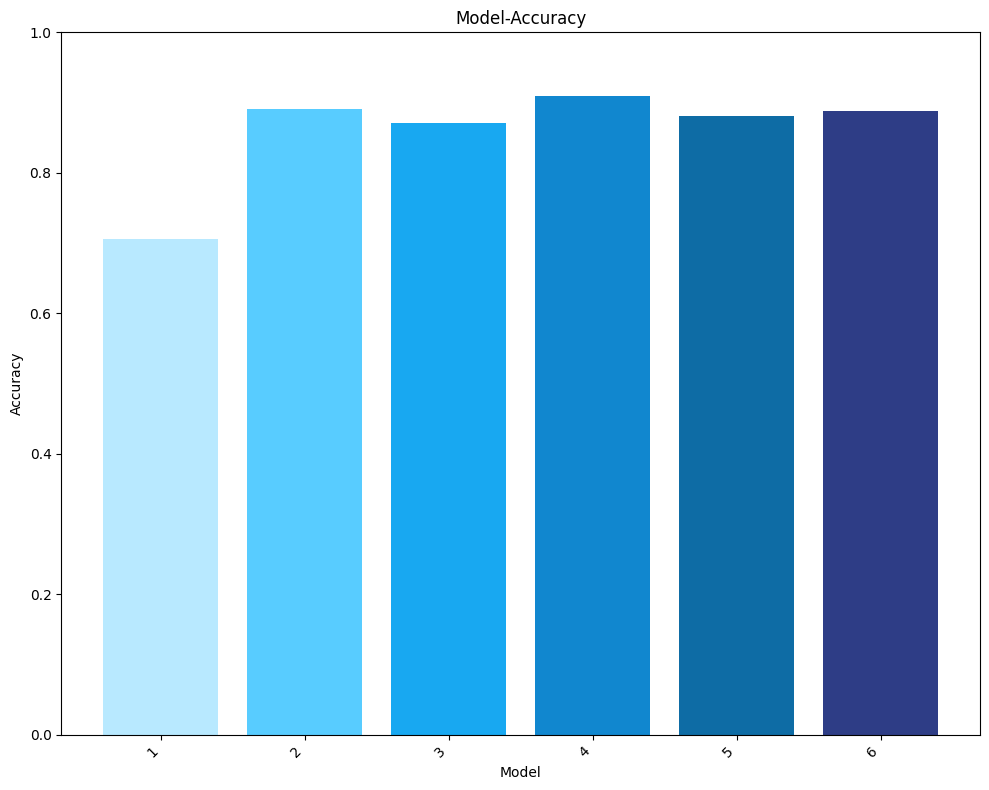

In [ ]:
import matplotlib.pyplot as plt

# 성능 지표 및 설정
models_VGG = [
    "Adam + Random",
    "AdamW + Random",
    "AdamW + Random + dropout 3",
    #"AdamW + Random + L2 + dropout 3",
    "AdamW + Random + L2 + dropout 6",
    #"Adamw + Random + L2 + dropout 6 + epoch 100 -> 200",
    "AdamW + Random + L2 + dropout 3 + Early stopping",
    #"AdamW + Random + L2 + dropout 3 + Early stopping + epoch 150 + batch_noramalization",
    #"Adamw + Random + L2 + dropout 3 + Early stopping + epoch 200 + batch_noramalization",
    "Adamw + Random + L2 + dropout 6 + Early stopping + batch_noramalization",
    #"Adamw + Random + L2 + dropout 6 + weight_decay"
]

models = [
    "1",
    "2",
    "3",
    "4",
    "5",
    "6"
]

accuracy_scores = [
    0.7055885910987854,
    0.8914704561233521,
    0.8707917928695679,
    #0.825571846961975,
    0.9095182180404663,
    #0.8489317059516907,
    0.8811646461486816,
    #0.9147465348243713,
    #0.90056973695755,
    0.8875827431678772,
    #0.8720569849014282
]

# 막대그래프 그리기
plt.figure(figsize=(10, 8))
plt.bar(models, accuracy_scores, color=['#B8E9FF','#58CCFF','#18A8F1','#1187CF','#0E6CA5','#2E3D86'])
plt.title('Model-Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # 정확도 범위에 따라 조절
plt.xticks(rotation=45, ha='right')



# 그래프 표시
plt.tight_layout()
plt.show()


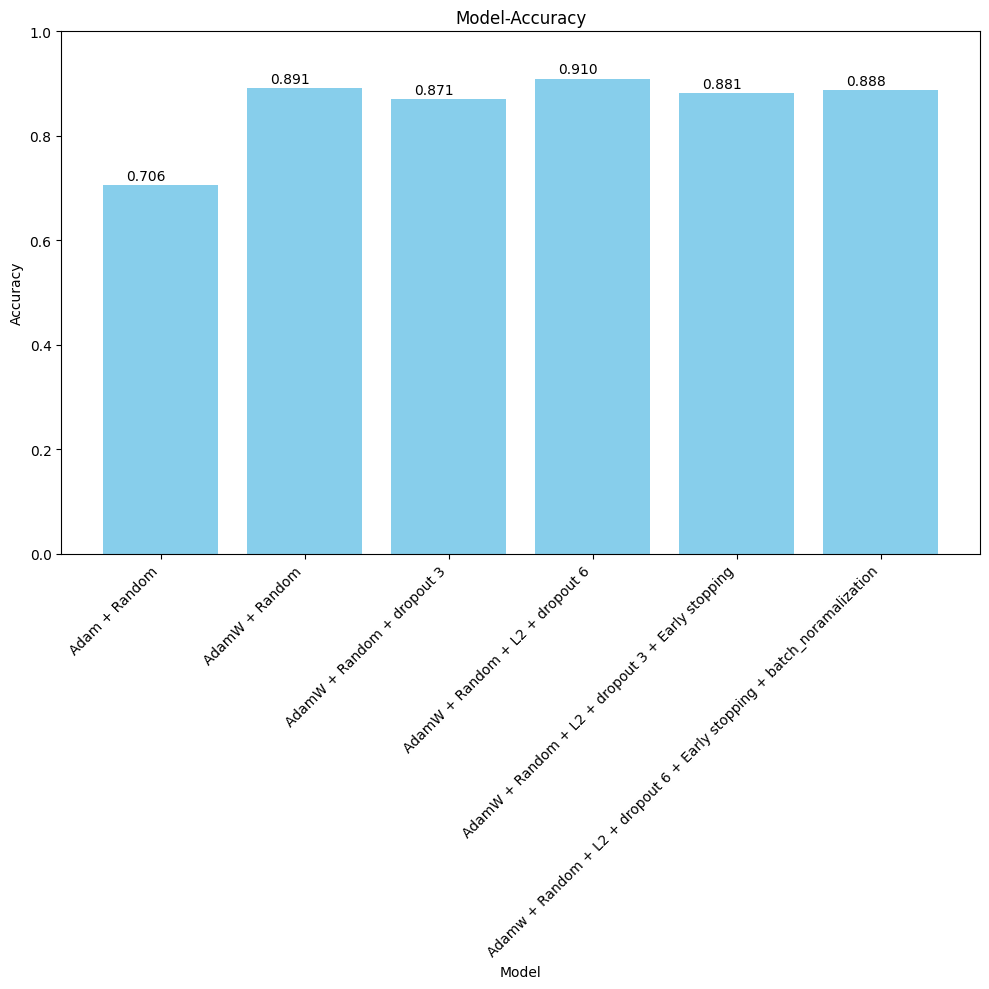

In [ ]:
import matplotlib.pyplot as plt

# 성능 지표 및 설정
models = [
    "Adam + Random",
    "AdamW + Random",
    "AdamW + Random + dropout 3",
    #"AdamW + Random + L2 + dropout 3",
    "AdamW + Random + L2 + dropout 6",
    #"Adamw + Random + L2 + dropout 6 + epoch 100 -> 200",
    "AdamW + Random + L2 + dropout 3 + Early stopping",
    #"AdamW + Random + L2 + dropout 3 + Early stopping + epoch 150 + batch_noramalization",
    #"Adamw + Random + L2 + dropout 3 + Early stopping + epoch 200 + batch_noramalization",
    "Adamw + Random + L2 + dropout 6 + Early stopping + batch_noramalization",
    #"Adamw + Random + L2 + dropout 6 + weight_decay"
]

accuracy_scores = [
    0.7055885910987854,
    0.8914704561233521,
    0.8707917928695679,
    #0.825571846961975,
    0.9095182180404663,
    #0.8489317059516907,
    0.8811646461486816,
    #0.9147465348243713,
    #0.90056973695755,
    0.8875827431678772,
    #0.8720569849014282
]

# 막대그래프 그리기
plt.figure(figsize=(10, 10))
bars = plt.bar(models, accuracy_scores, color='skyblue')
plt.title('Model-Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.ylim(0, 1)  # 정확도 범위에 따라 조절
plt.xticks(rotation=45, ha='right')

# 각 막대 위에 accuracy_scores 값을 소수점 3자리까지 나타내는 텍스트 추가
for bar, score in zip(bars, accuracy_scores):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.01, f'{score:.3f}', ha='center')

# 그래프 표시
plt.tight_layout()
plt.show()
